# Ground Truth - Exploring Tree Properties

> Data Provider: [Sustainable Landscapes GeoNetwork Catalog - Brazil](https://www.paisagenslidar.cnptia.embrapa.br/geonetwork/srv/spa/catalog.search#/metadata/44d96974-77b0-4e22-9fce-79609604bfd3) 

### Objective: 

* Develop a linear model to extract the coefficients in order to obtain the function that determines the best window size according to the tree height.

### Justification: 

* According to this [paper](https://sci-hub.se/10.5589/m08-055) (as well as other academic references), when working with LiDAR data from **places with a high density of trees**, such as the Amazon Rainforest, it is often advantageous to use variable and smoothed window sizes over Local Maxima algorithms (LM) to achieve higher performance and accuracy.

### Prodecure:

1. **Clip Coordinates:** Since the LiDAR file coordinates cover a smaller area than the inventory data, in order to ensure data parity, I will set up the inventory data to cover the same area as the LiDAR file.
2. **Basic Insights Exploration:** Determine the total number of living trees and unique species within the inventory data.
3. **Nan Handleing:** The inventory data does not have the meassurments of all the trees it reports. Therefore, I'll filter out all the null values. 
4. **Sample Basic Observation:** Understand the number of valid registers to work with and the species diversity in the sample data.
5. **Obtain Average Crown Size:** Since tree crowns are not perfect circles, the inventory data has measurments of crown radius taken from the center to the 4 cardinal points. I will calculate the average diameter. 
6. **Obtain and Evaluate Linear Model:** Apply and fit a Linear Regression model with Sci-kit Learn. Using *r-squared coefficient* to evaluate the model.

### Conclusions:

Given the current available data, **applying a variable window size (VWS) approach will not be of great benefit**; considering the great species diversity and insufficient samples, trying to fit and apply a unique function will likely result in poor generalization.

In this case, by fitting a linear regression model to the sample data, the obtained **r-squared value was 0.037.**

In order to continue with the ultimate project goal (learning to work with forest LiDAR data), I will proceed by applying a Fixed Window Size (FWS) approach.

#### Data Uploading & Library Importation:

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

import pandas as pd
import numpy as np

import plotly.express as px

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

df = pd.read_csv("/content/drive/MyDrive/Pachama/Sustainable Landscapes data/Inventory data/ANA_A01_2015_2018_Inventory_delivery.csv",encoding='ISO-8859-1')
df.sample(2)

area  plot  tree        common.name        scientific.name  \
1522  ANA_A01    13  019b         acariquara  Minquartia guianensis   
1422  ANA_A01    12  364a  abiurana vermelha    Pouteria gongrijpii   

     family.name type  DBH.2015 Dead.2015  D.class.2015  ...  RN.2015  \
1522   Olacaceae    O      11.5     False           NaN  ...      NaN   
1422  Sapotaceae    O      11.4     False           NaN  ...      NaN   

      RS.2015 RE.2015 RW.2015   date.2015 DBH.2018  Dead.2018  date.2018  \
1522      NaN     NaN     NaN  20150714.0     12.0      False   20180911   
1422      NaN     NaN     NaN  20150314.0     12.4      False   20180908   

      UTM.Easting  UTM.Northing  
1522  723398.6249   9627422.784  
1422  722898.3068   9627816.600  

[2 rows x 22 columns]

In [ ]:
df.dtypes

area                object
plot                 int64
tree                object
common.name         object
scientific.name     object
family.name         object
type                object
DBH.2015           float64
Dead.2015           object
D.class.2015       float64
Hcom.2015          float64
Htot.2015          float64
RN.2015             object
RS.2015             object
RE.2015             object
RW.2015             object
date.2015          float64
DBH.2018           float64
Dead.2018             bool
date.2018            int64
UTM.Easting        float64
UTM.Northing       float64
dtype: object

### Coordinate Clipping:

In [ ]:
# Obtain the inventory geographic boundaries
print("Western coordinate", df['UTM.Easting'].min())
print("Eastern coordinate", df['UTM.Easting'].max())
print("Southern coordinate", df['UTM.Northing'].min())
print("Northern coordinate", df['UTM.Northing'].max())

Western coordinate 721670.588
Eastern coordinate 723438.7275
Southern coordinate 9627173.853
Northern coordinate 9629421.855


In [ ]:
### Clip coordinates to fit .las file boundaries
df = df[(df['UTM.Easting'] >= 721917.4) & (df['UTM.Easting'] <= 722917.4)]
df = df[(df['UTM.Northing'] >= 9627871) & (df['UTM.Northing'] <= 9628871)]

### Basic Insights Exploration:

In [ ]:
print("Total number of trees on the inventory:", df.shape[0])
print("Average trees per squared meter:", df.shape[0]/80000)
print("Total alive trees: ", df[df['Dead.2015']==False].shape[0])
print("Percentage of living trees in inventory:", str(round(((df[df['Dead.2015']==False].shape[0]/df.shape[0])*100),2))+"%")

Total number of trees on the inventory: 1168
Average trees per squared meter: 0.0146
Total alive trees:  1080
Percentage of living trees in inventory: 92.47%


In [ ]:
print("Total different species contained:", df['scientific.name'].unique().shape[0])

Total different species contained: 172


### Nan Handling:

In [ ]:
### Drop all Nan values
df2 = df.dropna(subset=['Hcom.2015','Htot.2015','RN.2015','RS.2015','RE.2015','RW.2015'], how='all').drop(columns=["type"])

### Filtering out reamining Nan values
df2['RN.2015'] = pd.to_numeric(df['RN.2015'], errors='coerce')
df2 = df2[pd.notnull(df2['RN.2015'])]
df2 = df2[~df2['Hcom.2015'].isnull()]
df2.sample(10)

area  plot  tree        common.name         scientific.name  \
2069  ANA_A01    17  040a         piquiarana        Caryocar glabrum   
2618  ANA_A01    21  062a        macaranduba        Manilkara huberi   
3591  ANA_A01    30  063a    guajara-bolacha  Pouteria oppositifolia   
2283  ANA_A01    19  144a    abiurana branca     Pouteria guianensis   
825   ANA_A01     7  132b            goiabao     Pradosia cochlearia   
2427  ANA_A01    20  210b            goiabao     Pradosia cochlearia   
2483  ANA_A01    20  244b    abiurana branca     Pouteria guianensis   
2305  ANA_A01    19  155a      inga vermelho               Inga alba   
674   ANA_A01     6  059b  castanha-sapucaia        Lecythis pisonis   
855   ANA_A01     8  142a   castanha-do-para    Bertholletia excelsa   

        family.name  DBH.2015 Dead.2015  D.class.2015  Hcom.2015  ...  \
2069  Caryocaraceae     110.0     False           NaN      21.00  ...   
2618     Sapotaceae      90.0     False           NaN      36.55  ...   
3591     Sapotaceae      56.8     False           NaN      24.56  ...   
2283     Sapotaceae      56.0     False           NaN      31.92  ...   
825      Sapotaceae      57.0     False           NaN      26.13  ...   
2427     Sapotaceae      50.0     False           NaN      28.09  ...   
2483     Sapotaceae      59.0     False           NaN      30.68  ...   
2305       Fabaceae      68.0     False           NaN      25.97  ...   
674   Lecythidaceae      80.0     False           NaN      32.17  ...   
855   Lecythidaceae      87.2     False           NaN      31.42  ...   

      RN.2015  RS.2015 RE.2015 RW.2015   date.2015  DBH.2018  Dead.2018  \
2069     14.8     12.2    16.3    11.8  20150318.0     157.6      False   
2618      8.6     10.3    10.3     8.6  20150319.0      95.5      False   
3591      7.2      6.8       2      12  20150717.0       NaN       True   
2283      5.2      5.2     4.1     6.2  20150318.0      55.7      False   
825       6.7      4.3     5.2     4.8  20150316.0      57.6      False   
2427      6.2      5.2     4.1     5.3  20150318.0      50.0      False   
2483      5.3      4.1     6.2     5.5  20150318.0      50.3      False   
2305      6.7      7.8       6     6.8  20150318.0      67.7      False   
674       6.8      7.9     8.6     9.2  20150316.0     132.1      False   
855      10.0     13.4    11.7     7.7  20150316.0      89.8      False   

      date.2018  UTM.Easting  UTM.Northing  
2069   20180908  722603.9400   9628277.166  
2618   20180910  722091.3321   9628533.359  
3591   20180912  722904.8440   9628853.508  
2283   20180908  722615.7693   9628539.145  
825    20180905  722337.4350   9628029.724  
2427   20180908  722642.8105   9628708.488  
2483   20180908  722653.6433   9628714.808  
2305   20180908  722611.4201   9628567.887  
674    20180907  722354.5157   9627874.569  
855    20180905  722306.4868   9628153.245  

[10 rows x 21 columns]

In [ ]:
df2 = df2.drop(columns=["D.class.2015"])
df2.isnull().sum()

area                0
plot                0
tree                0
common.name         1
scientific.name     1
family.name         1
DBH.2015            0
Dead.2015           0
Hcom.2015           0
Htot.2015           0
RN.2015             0
RS.2015             0
RE.2015             0
RW.2015             0
date.2015           0
DBH.2018           15
Dead.2018           0
date.2018           0
UTM.Easting         0
UTM.Northing        0
dtype: int64

### Sample observed characteristics:

In [ ]:
# Obtain total number of living trees with data to work in the sample
df2['Dead.2015'].value_counts()

False    74
Name: Dead.2015, dtype: int64

In [ ]:
# Obtain total number of species within the sample data
print("Total different species contained:", df2['scientific.name'].unique().shape[0])

Total different species contained: 40


In [ ]:
# Validate total number of registers in sample data
df2.shape

(74, 21)

In [ ]:
# Observing the number of repeated species to grasp the biodiversity in the sample
df2['scientific.name'].value_counts()

Pouteria guianensis             7
Couratari stellata              5
Caryocar glabrum                5
Lecythis lurida                 4
Manilkara huberi                4
Tachigali paniculata            4
Tachigali myrmecophila          3
Terminalia amazonia             3
Hevea brasiliensis              2
Virola mollissima               2
Eschweilera coriacea            2
Maquira coriacea                2
Bowdichia nitida                2
Pradosia cochlearia             2
Enterolobium schomburgkii       2
Agonandra brasiliensis          1
Virola elongata                 1
Eschweilera parviflora          1
Hymenaea parvifolia             1
Dimorphandra macrostachya       1
Jacaranda copaia                1
Pouteria oppositifolia          1
Coussarea brevicaulis           1
Goupia glabra                   1
Pouteria gongrijpii             1
Rinorea guianensis              1
Stryphnodendron pulcherrimum    1
Mezilaurus itauba               1
Inga alba                       1
Inga marginata

> For the current dataset with a tree **population of 1080 living trees**, using the 74 trees with measurement data to create a sample will allow for estimating results with a **90% confidence level and a 9% margin of error**. However, it is important to consider that **this sample will only cover 23.25% of the total species**, and most of the observed species do not appear multiple times in the sample.

### Obtain Average Crown Size:

In [ ]:
# Filtering all columns that contain crown radius related data
Window_size_calculation_df = df2.iloc[:, [6, 8, 9, 10, 11, 12, 13]]
Window_size_calculation_df = Window_size_calculation_df.apply(pd.to_numeric)
Window_size_calculation_df.sample(2)

DBH.2015  Hcom.2015  Htot.2015  RN.2015  RS.2015  RE.2015  RW.2015
774       68.0      13.98      26.41     15.7      5.1      4.2      5.2
2277      66.9      27.26      35.82      5.2      4.2      3.1      3.7

In [ ]:
def average_crown_diameter(row):
  diameter_1 = row['RN.2015'] + row['RS.2015']
  diameter_2 = row['RE.2015'] + row['RW.2015']
  return (diameter_1+diameter_2)/2

Window_size_calculation_df['avg_crown_size'] = Window_size_calculation_df.apply(average_crown_diameter, axis=1)

In [ ]:
Window_size_calculation_df.head(2)

DBH.2015  Hcom.2015  Htot.2015  RN.2015  RS.2015  RE.2015  RW.2015  \
653      59.4      30.48      47.20      6.1      4.4      5.4      5.1   
674      80.0      32.17      53.18      6.8      7.9      8.6      9.2   

     avg_crown_size  
653           10.50  
674           16.25

### Obtain and Evaluate Linear Model:

In [ ]:
fig = px.scatter(Window_size_calculation_df,
                 x="Htot.2015", y=("avg_crown_size"))
fig.show()

* At first glance, it appears that there is not a strong correlation between tree height and crown size.

In [ ]:
#Define X & Y values for Linear Regresion
X = Window_size_calculation_df['Htot.2015'].to_numpy().reshape(-1, 1)
y = Window_size_calculation_df['avg_crown_size']

#Fit Linear Regression to the data
reg = LinearRegression().fit(X, y)
predictions = reg.predict(X)

# Obtain r-squared coefficient
r2_score(y, predictions)

0.03667282341233591

In [ ]:
# Obtain LR coefficients 
print("coef:", reg.coef_)
print("intercept:",reg.intercept_)

coef: [0.1370734]
intercept: 6.298363956250762


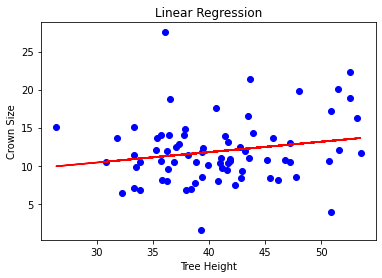

In [ ]:
# Visualising the Linear Regression results
import matplotlib.pyplot as plt

plt.scatter(X, y, color = 'blue')

plt.plot(X, reg.predict(X), color = 'red')
plt.title('Linear Regression')
plt.xlabel('Tree Height')
plt.ylabel('Crown Size')

plt.show()